### Task 1 less than k

Given a positive integer “k” and a list of integer numbers, look for the numbers within the list, that are less than k. Consider an appropriate number of qubits and explain why your proposal is valid for all kinds of numbers in case 

def less_than_k (int:k, list[int] ,list_n):
     “””
k : integer value that is the positive number to compare in list_n,
list_n : integer list that has positive numbers.
Return the numbers that are in list_n and are less than k 
     “””

     # use a framework that works with quantum circuits, qiskit, cirq, pennylane, etc. 

      # consider print your quantum circuit,

Example:

A = less_than_k (7,[4,9,11,14,1,13,6,15])
print(A)

“4,1,6”

In [23]:
import math

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.quantum_info import Statevector, Operator, DensityMatrix
from qiskit.circuit.library import GroverOperator, MCMT, ZGate, MCMT, ZGate, XGate
from qiskit.visualization import plot_distribution, array_to_latex
from qiskit.primitives import Sampler
from qiskit_aer import AerSimulator, StatevectorSimulator

import numpy as np

In [24]:
def rev_bin(value: int, zeros: int):
    return bin(value)[2:].zfill(zeros)[::-1]

In [25]:
def state_preparation(list_n: list[int], num_index_qubits: int, num_value_qubits: int, debug: bool = False) -> QuantumCircuit:
    """
    This function prepares the quantum state for the less_than_k algorithm.

    The state preparation operation encodes the input list of numbers into a quantum state using qubits for the index and value of each number. The index qubits are used to represent the position of each number in the list, while the value qubits are used to represent the value of each number.

    Parameters:
    list_n (list[int]): The list of numbers to be encoded.
    num_index_qubits (int): The number of qubits used to represent the index of each number in the list.
    num_value_qubits (int): The number of qubits used to represent the value of each number in the list.
    debug (bool, optional): A flag to enable debug mode. Defaults to False.

    Returns:
    QuantumCircuit: The quantum circuit for the state preparation operation.
    """
    addr = QuantumRegister(num_index_qubits, "addr")
    data = QuantumRegister(num_value_qubits, "data")

    qc = QuantumCircuit(addr, data)

    for (i, v) in enumerate(list_n):
        index_bin_rep = rev_bin(i, num_index_qubits)

        zero_inds = [ind for ind in range(num_index_qubits) if index_bin_rep.startswith("0", ind)]
        if zero_inds:
            qc.x(zero_inds)

        value_bin_rep = rev_bin(v, num_value_qubits)

        one_inds = [ind for ind in range(num_value_qubits) if value_bin_rep.startswith("1", ind)]
        for ind in one_inds:
            qc.mcx(addr, data[ind])

        if zero_inds:
            qc.x(zero_inds)

        qc.barrier()

    return qc

In [26]:
def oracle(k: int, list_n: list[int], num_index_qubits: int, num_value_qubits: int, debug: bool = False):
    """
    This function implements the oracle operation in the less_than_k algorithm.

    The oracle operation marks all the numbers in the list that are less than the specified value k. It does this by comparing each number in the list with k and flipping the corresponding bits in a binary representation of the number. The marked numbers are then used to search for solutions in the final step of the algorithm.

    Parameters:
    k (int): The value to compare each number in the list with.
    list_n (list[int]): The list of numbers to be searched.
    num_index_qubits (int): The number of qubits used to represent the index of each number in the list.
    num_value_qubits (int): The number of qubits used to represent the value of each number in the list.
    debug (bool, optional): A flag to enable debug mode. Defaults to False.

    Returns:
    QuantumCircuit: The oracle operation as a quantum circuit.

    """
    qc = QuantumCircuit(num_index_qubits)

    for (i, n) in enumerate(list_n):
        if n < k:
            index_bin_rep = rev_bin(i, num_index_qubits)
            value_bin_rep = rev_bin(n, num_value_qubits)

            if debug: print(f'{i} - {n} --> {index_bin_rep} --> {value_bin_rep}')

            zero_inds = [ind for ind in range(num_index_qubits) if index_bin_rep.startswith("0", ind)]

            if zero_inds:
                qc.x(zero_inds)

            qc.compose(MCMT(ZGate(), num_index_qubits - 1, 1), inplace=True)

            if zero_inds:
                qc.x(zero_inds)

            qc.barrier()

    return qc

In [27]:
def diffusion_operator(num_qubits: int) -> QuantumCircuit:
    qc = QuantumCircuit(num_qubits)

    for qubit in range(num_qubits):
        qc.h(qubit)
    for qubit in range(num_qubits):
        qc.x(qubit)

    qc.barrier(range(num_qubits))

    qc.h(num_qubits - 1)
    qc.mcx(list(range(num_qubits - 1)), num_qubits - 1)
    qc.h(num_qubits - 1)

    qc.barrier(range(num_qubits))

    for qubit in range(num_qubits):
        qc.x(qubit)
    for qubit in range(num_qubits):
        qc.h(qubit)

    return qc

In [28]:
def get_indexes(dist, m: int, debug: bool = False) -> list[int]:
    probabilities = list(dist.values())

    average_probability = np.mean(probabilities)
    max_probability = max(probabilities)
    threshold = 0.1

    if debug:
        print(f'Probabilities: {probabilities} are sum to {sum(probabilities)}')
        print(f'Average probability: {average_probability}')
        print(f'Max probability: {max_probability}')

    indexes = [index for index, prob in dist.items() if np.abs(max_probability - prob) <= threshold]
    if len(indexes) != m:
        raise ValueError(f'The number of indexes is not equal to the number of solutions: {len(indexes)}!= {m} in probabilities distribution {dist}')
    return indexes

In [29]:
def calculate_solutions(k: int, list_n: list[int]):
    return [n for n in list_n if n < k]

In [33]:
def less_than_k(k: int, list_n: list[int], debug: bool = False):
    """
    k : integer value that is the positive number to compare in list_n,
    list_n : integer list that has positive numbers.
    Return the numbers that are in list_n and are less than k
    """
    for n in list_n:
        if not isinstance(n, int) or n <= 0:
            raise ValueError('Array must contain only positive integer numbers')

    solutions = calculate_solutions(k, list_n)
    m = len(solutions)

    if debug: print(f'Number of solutions: {m}')

    if m == 0:
        return []
    elif len(solutions) >= len(list_n) / 2:
        return solutions

    num_index_qubits = int(np.ceil(np.log2(len(list_n))))
    num_value_qubits = int(np.ceil(np.log2(max(list_n))))
    total_qubits = num_index_qubits + num_value_qubits
    N = 2 ** num_index_qubits
    optimal_num_iterations = math.floor(
        (math.pi / 4) * math.sqrt(N / m)
    )

    if debug:
        print(f"{num_index_qubits} qubits for index and {num_value_qubits} qubits for data in array")
        print(f'Optimal number of iterations: {optimal_num_iterations}')

    qc = QuantumCircuit(total_qubits, num_index_qubits)
    qc.h(range(num_index_qubits))

    qc.barrier()

    for i in range(optimal_num_iterations):
        S = state_preparation(list_n, num_index_qubits, num_value_qubits, debug)
        S.name = "S"
        qc.append(S, range(total_qubits))

        if debug:
            print(f"After state preparation operation (iteration {i})")
            display(array_to_latex(StatevectorSimulator().run(qc.decompose(reps=2)).result().get_statevector(), max_size=128))

        oracle_operator = oracle(k, list_n, num_index_qubits, num_value_qubits, debug)
        oracle_operator.name = 'Oracle'
        qc.append(oracle_operator, range(num_index_qubits))

        if debug:
            print(f"After oracle operation (iteration {i})")
            display(array_to_latex(StatevectorSimulator().run(qc.decompose(reps=2)).result().get_statevector(), max_size=128))

        S_inv = S.inverse()
        S_inv.name = "S_inv"
        qc.append(S_inv, range(total_qubits))

        diffusion_op = diffusion_operator(num_index_qubits)
        diffusion_op.name = 'D'
        qc.append(diffusion_op, range(num_index_qubits))

        if debug:
            print(f"After amplification operation (iteration {i})")
            display(array_to_latex(StatevectorSimulator().run(qc.decompose(reps=2)).result().get_statevector(), max_size=128))

        qc.barrier()

    qc.measure(range(num_index_qubits), range(num_index_qubits))

    dist = Sampler().run(qc, shots=1024).result().quasi_dists[0]
    indexes = get_indexes(dist, m, debug)
    if debug: display(plot_distribution(dist, figsize=(7, 2)))

    return [list_n[index] for index in indexes]

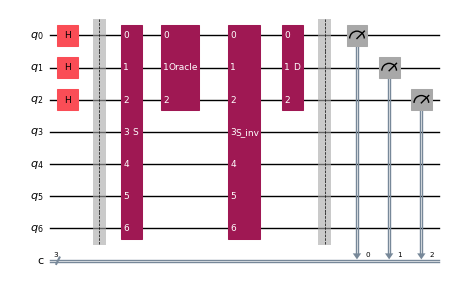

[4, 1, 6]


In [34]:
k = 7
list_n = [4, 9, 11, 14, 1, 13, 6, 15]
A = less_than_k(k, list_n)
print(A)

References:

[1] Deutsch, David, and Richard Jozsa. "Rapid solution of problems by quantum computation." Proceedings of the Royal Society of London. Series A: Mathematical and Physical Sciences 439.1907 (1992): 553-558.

[2] Bernstein, Ethan, and Umesh Vazirani. "Quantum complexity theory." SIAM Journal on computing 26.5 (1997): 1411-1473.

[3] Grover, Lov K. , "A fast quantum mechanical algorithm for database search", Proceedings of the 28th Annual ACM Symposium on the Theory of Computing (1996), arXiv:quant-ph/9605043

In [32]:
import unittest
from parameterized import parameterized

class TestTask1(unittest.TestCase):

    @parameterized.expand([
        (7, [2, 5, -6, 6]),
        (7, [2, 5, 1, 4.21, 6])
    ])
    def test_positive_intigers_in_array(self, k, list_n):
        with self.assertRaises(ValueError):
            less_than_k(k, list_n)

    def test_empty_array(self):
        self.assertEqual(less_than_k(7, []), [])

    @parameterized.expand([
        (7, [4, 9, 2, 14, 1, 13, 6, 15], [4, 2, 1, 6]),
        (7, [4, 9, 11, 14, 1, 13, 6, 15], [4, 1, 6]),
        (7, [4, 9, 11, 14, 10, 13, 6, 15], [4, 6]),
        (7, [12, 9, 11, 14, 10, 13, 6, 15], [6]),
        (7, [12, 9, 11, 14, 10, 13, 7, 15], [])
    ])
    def test_search_in_array(self, k, list_n, expected_result):
        self.assertEqual(less_than_k(k, list_n), expected_result)

    @parameterized.expand([
        (7, [1, 9, 11, 1, 14, 13, 6, 15], [1, 1, 6]),
        (7, [4, 9, 11, 14, 4, 13, 6, 15], [4, 4, 6]),
        (7, [6, 9, 11, 14, 6, 13, 6, 15], [6, 6, 6]),
        (7, [1, 9, 11, 14, 1, 13, 8, 15], [1, 1])
    ])
    def test_search_in_array_with_duplicates(self, k, list_n, expected_result):
        self.assertEqual(less_than_k(k, list_n), expected_result)

unittest.main(argv=[''], verbosity=2, exit=False)

test_empty_array (__main__.TestTask1.test_empty_array) ... ok
test_positive_intigers_in_array_0 (__main__.TestTask1.test_positive_intigers_in_array_0) ... ok
test_positive_intigers_in_array_1 (__main__.TestTask1.test_positive_intigers_in_array_1) ... ok
test_search_in_array_0 (__main__.TestTask1.test_search_in_array_0) ... ok
test_search_in_array_1 (__main__.TestTask1.test_search_in_array_1) ... ok
test_search_in_array_2 (__main__.TestTask1.test_search_in_array_2) ... ok
test_search_in_array_3 (__main__.TestTask1.test_search_in_array_3) ... ok
test_search_in_array_4 (__main__.TestTask1.test_search_in_array_4) ... ok
test_search_in_array_with_duplicates_0 (__main__.TestTask1.test_search_in_array_with_duplicates_0) ... ok
test_search_in_array_with_duplicates_1 (__main__.TestTask1.test_search_in_array_with_duplicates_1) ... ok
test_search_in_array_with_duplicates_2 (__main__.TestTask1.test_search_in_array_with_duplicates_2) ... ok
test_search_in_array_with_duplicates_3 (__main__.TestTask1